**Problem 1**
**part 1**


Best MSE: 90.06, Parameters: {'size': 3, 'sigma': 1}


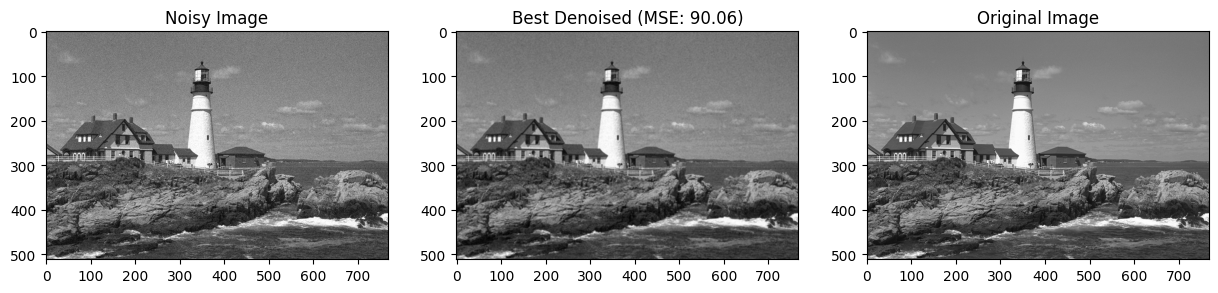

In [19]:
import cv2
import numpy as np
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

original = cv2.imread('lighthouse2.bmp', cv2.IMREAD_GRAYSCALE).astype(np.float32)
h, w = original.shape

noise = np.random.normal(0, 10, (h, w))
noisy = original + noise
noisy = np.clip(noisy, 0, 255).astype(np.uint8)

filter_sizes = [3, 7, 11]
sigmas = [0.1, 1, 2, 4, 8]
best_mse = float('inf')
best_denoised = None
best_params = {}

for size in filter_sizes:
    for sigma in sigmas:
        denoised = cv2.GaussianBlur(noisy, (size, size), sigmaX=sigma)
        denoised = denoised.astype(np.float32)

        mse = mean_squared_error(original, denoised)

        if mse < best_mse:
            best_mse = mse
            best_denoised = denoised
            best_params = {'size': size, 'sigma': sigma}

print(f"Best MSE: {best_mse:.2f}, Parameters: {best_params}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(1, 3, 2), plt.imshow(best_denoised, cmap='gray'),
plt.title(f'Best Denoised (MSE: {best_mse:.2f})')
plt.subplot(1, 3, 3), plt.imshow(original, cmap='gray'), plt.title('Original Image')
plt.show()

**part 2**

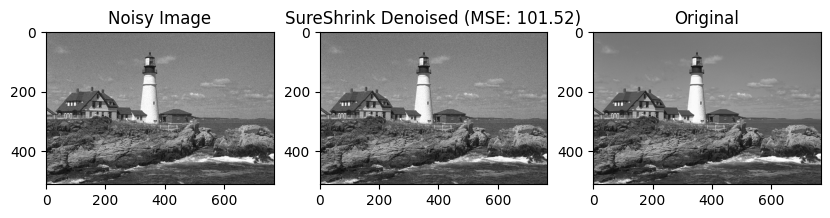

In [18]:
import pywt
from scipy.stats import norm

def sure_threshold(coeffs, sigma):
    n = coeffs.size
    coeffs_sq = coeffs**2
    t_candidates = np.linspace(0, 3*sigma, 100)
    sure_risks = []

    for t in t_candidates:
        mask = (coeffs_sq <= t**2)
        sure = n * sigma**2 + np.sum(np.minimum(coeffs_sq, t**2) - 2 * sigma**2 * (~mask))
        sure_risks.append(sure)

    t_opt = t_candidates[np.argmin(sure_risks)]
    return t_opt

noisy_float = noisy.astype(np.float32)

coeffs = pywt.wavedec2(noisy_float, 'db4', level=2)
sigma = 10

new_coeffs = [coeffs[0]]
for detail in coeffs[1:]:
    t = sure_threshold(detail[0], sigma)
    thresh_detail = [pywt.threshold(c, t, mode='soft') for c in detail]
    new_coeffs.append(thresh_detail)

denoised_wavelet = pywt.waverec2(new_coeffs, 'db4')
denoised_wavelet = np.clip(denoised_wavelet, 0, 255).astype(np.uint8)
mse_wavelet = mean_squared_error(original, denoised_wavelet)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(1, 3, 2), plt.imshow(denoised_wavelet, cmap='gray'),
plt.title(f'SureShrink Denoised (MSE: {mse_wavelet:.2f})')
plt.subplot(1, 3, 3), plt.imshow(original, cmap='gray'), plt.title('Original')
plt.show()

**part 3**

In [25]:
def multiscale_sureshrink(image, scales=3):
    original_h, original_w = image.shape
    current = image.copy().astype(np.float32)
    coeffs_list = []

    for _ in range(scales):
        coeffs = pywt.wavedec2(current, 'db4', level=1, mode='symmetric')
        coeffs_list.append(coeffs)
        current = coeffs[0]

    for i in range(scales):
        coeffs = coeffs_list[i]
        new_coeffs = [coeffs[0]]
        for detail in coeffs[1:]:
            t = sure_threshold(detail[0], sigma)
            new_detail = [pywt.threshold(c, t, mode='soft') for c in detail]
            new_coeffs.append(new_detail)
        coeffs_list[i] = new_coeffs

    denoised = coeffs_list[-1][0]
    for i in reversed(range(scales-1)):
        target_shape = coeffs_list[i][0].shape
        denoised_resized = cv2.resize(denoised, (target_shape[1], target_shape[0]))
        denoised = pywt.waverec2([denoised_resized] + coeffs_list[i][1:], 'db4', mode='symmetric')

    denoised = cv2.resize(denoised, (original_w, original_h))
    denoised = np.clip(denoised, 0, 255).astype(np.uint8)
    return denoised

mse_scales = []
for scales in range(1, 5):
    denoised = multiscale_sureshrink(noisy, scales)
    mse = mean_squared_error(original, denoised)
    mse_scales.append(mse)
    print(f"Scales: {scales}, MSE: {mse:.2f}")

Scales: 1, MSE: 10772.87
Scales: 2, MSE: 10860.16
Scales: 3, MSE: 11202.57
Scales: 4, MSE: 11786.00


**Problem 2**

In [28]:
pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 11.6 MB/s eta 0:00:00


**part 1**

Stage 1 MSE: 34.07
Stage 2 MSE: 29.15


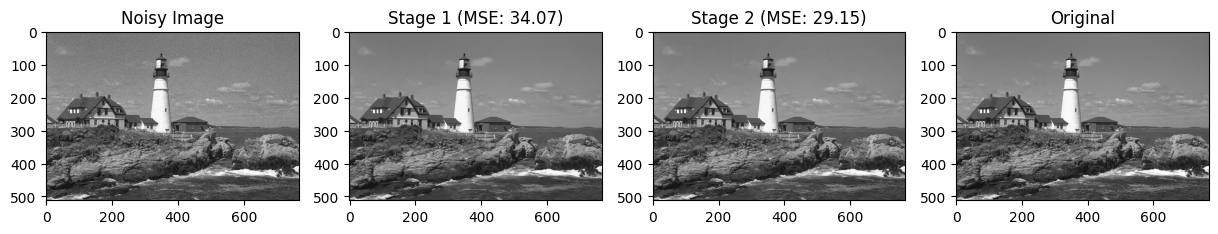

In [30]:
import cv2
import numpy as np
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
import bm3d

original = cv2.imread('lighthouse2.bmp', cv2.IMREAD_GRAYSCALE)
h, w = original.shape

noise = np.random.normal(0, 10, (h, w)).astype(np.float32)
noisy = original.astype(np.float32) + noise
noisy = np.clip(noisy, 0, 255).astype(np.uint8)

noisy_normalized = noisy.astype(np.float32) / 255.0


denoised_stage1 = bm3d.bm3d(
    noisy_normalized,
    sigma_psd=10/255,
    stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING
)
denoised_stage1 = (denoised_stage1 * 255).clip(0, 255).astype(np.uint8)
mse_stage1 = mean_squared_error(original, denoised_stage1)

denoised_stage2 = bm3d.bm3d(noisy_normalized, sigma_psd=10/255)
denoised_stage2 = (denoised_stage2 * 255).clip(0, 255).astype(np.uint8)
mse_stage2 = mean_squared_error(original, denoised_stage2)

print(f"Stage 1 MSE: {mse_stage1:.2f}")
print(f"Stage 2 MSE: {mse_stage2:.2f}")


plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(1, 4, 2), plt.imshow(denoised_stage1, cmap='gray'), plt.title(f'Stage 1 (MSE: {mse_stage1:.2f})')
plt.subplot(1, 4, 3), plt.imshow(denoised_stage2, cmap='gray'), plt.title(f'Stage 2 (MSE: {mse_stage2:.2f})')
plt.subplot(1, 4, 4), plt.imshow(original, cmap='gray'), plt.title('Original')
plt.show()

**part 2**

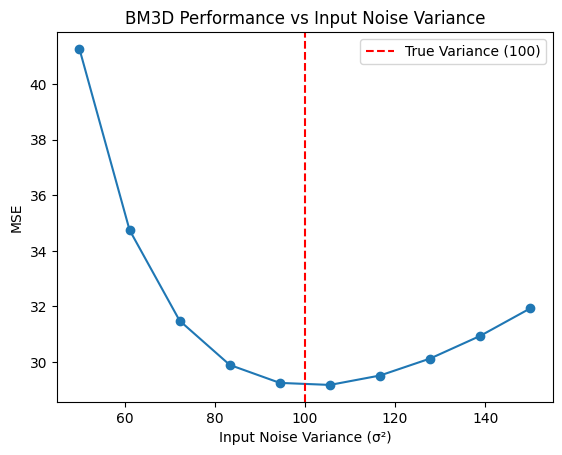

In [31]:
sigmas = np.sqrt(np.linspace(50, 150, 10))
mse_values = []

for sigma in sigmas:
    denoised = bm3d.bm3d(
        noisy_normalized,
        sigma_psd=sigma/255  #[0,1]
    )
    denoised = (denoised * 255).clip(0, 255).astype(np.uint8)
    mse = mean_squared_error(original, denoised)
    mse_values.append(mse)


plt.plot(sigmas**2, mse_values, marker='o')
plt.axvline(x=100, color='r', linestyle='--', label='True Variance (100)')
plt.xlabel('Input Noise Variance (σ²)')
plt.ylabel('MSE')
plt.title('BM3D Performance vs Input Noise Variance')
plt.legend()
plt.show()